In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


Import the libraries we need

In [ ]:
import xlrd
import statsmodels.api as sm
## gdal
from osgeo import gdal, gdal_array
import numpy as np
from numpy.linalg import inv
from scipy.stats.distributions import chi2
from itertools import chain
import matplotlib.pyplot as plt
from osgeo import ogr
## AI
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score, f1_score, precision_score, recall_score

Convert your SHP with the classification of differenct coverages to raster




In [ ]:
raster = gdal.Open('/content/gdrive/My Drive/Whanganui/Rrs20230727_cl_re.tif') ##Please merge your individual band to one Gtiff if you are using Sentinel-2 data  ##Make sure your tif file has Band Blue, Green, Red and NIR.
vector = ogr.Open('/content/gdrive/My Drive/Whanganui/classification.shp')

lyr = vector.GetLayer()
geot = raster.GetGeoTransform()
proj = raster.GetProjectionRef()

vec_raster = gdal.GetDriverByName('GTiff')
chn_ras = vec_raster.Create('/content/gdrive/My Drive/Whanganui/classification_ras.tif',raster.RasterXSize,raster.RasterYSize,1,gdal.GDT_Byte)
chn_ras.SetGeoTransform(geot)
chn_ras.SetProjection(proj)
gdal.RasterizeLayer(chn_ras, [1], lyr, options=['ATTRIBUTE=id']) # the field name should correspond to the classificaiton that you would like to use for supervised classification
chn_ras.GetRasterBand(1).SetNoDataValue(0)
chn_ras = None

### in the shapefile:
###Class 1: Sparse seagrass
###Class 2: Dense seagrass
###Class 3: Exposed sediments
###Class 4: Water
###Class 5: Interfaces of water and exposed sediments
## This process can also be done in ArcGIS or QGIS.

In [ ]:
vector_raster = gdal.Open('/content/gdrive/My Drive/Whanganui/classification_ras.tif')
vec = vector_raster.GetRasterBand(1).ReadAsArray()

##Create a 3D matrix to save the result
width = raster.RasterYSize; lenth = raster.RasterXSize; number = raster.RasterCount
container = np.ones((width, lenth, number),gdal_array.GDALTypeCodeToNumericTypeCode(raster.GetRasterBand(1).DataType))
for i in range(number):
  container[:,:,i] = raster.GetRasterBand(i+1).ReadAsArray().astype(np.float32)
fit_X  = container[vec>0,:]
fit_y  = vec[vec>0]

In [ ]:
fit_X_train, fit_X_test, fit_y_train, fit_y_test = train_test_split(fit_X,fit_y,test_size = 0.8)

Find the best model parameters

In [ ]:
Accuracy = []
for i in range(20,500,20):##find out the optimum tree numbers for supervised classification
   for j in range(2,10,2):##find out the optimum min_samples_split
     for k in range(1,5,1):##find out the optimum min_samples_leaf
        for l in range(70,120,10):##find out the optimum max depth
            RandomForest = RandomForestClassifier(n_estimators=i,min_samples_split=j,min_samples_leaf=k,max_depth=l)
            randomforest = RandomForest.fit(fit_X_train,fit_y_train)
            y_predict = randomforest.predict(fit_X_test)
            AS = accuracy_score(fit_y_test, y_predict)
            result = [AS, i, j, k, l]
            Accuracy.append(result)

r = []
for i in range(len(Accuracy)):
  r.append(Accuracy[i][0])
print(np.nanmax(r))
idx = r.index(max(r))
print("The optimum estimator, min sample split, min sample leaf, max depth are",(Accuracy[idx][1]),(Accuracy[idx][2]),(Accuracy[idx][3]),(Accuracy[idx][4]),"respectively")
### This process is usually long.. But honestly, even if we set the non-optimal values for the paramters, the results are barely affected.

Train and save the model

In [ ]:
RandomForest = RandomForestClassifier(n_estimators=280,min_samples_split=4,min_samples_leaf=4,max_depth=20)
randomforest = RandomForest.fit(fit_X_train,fit_y_train)
y_predict = randomforest.predict(fit_X_test)


In [ ]:
# Make classification report, Kappa coefficient of the prediction
print('Accuracy: ', accuracy_score(fit_y_test, y_predict))
print('Kappa: ', cohen_kappa_score(fit_y_test, y_predict))
print('Classification report: ')
print(classification_report(fit_y_test, y_predict)) ### The seagrass low density seems to have a lower precision

Apply the model

In [ ]:
Final_container = (container.shape[0]*container.shape[1],container.shape[2])

In [ ]:
Final_container_re = container[:,:,:4].reshape(Final_container)

In [ ]:
supervised_classification = randomforest.predict(Final_container_re)

In [ ]:
supervised_classification = supervised_classification.reshape(container[:,:,0].shape)

Review the result and export the map with georeferrencing

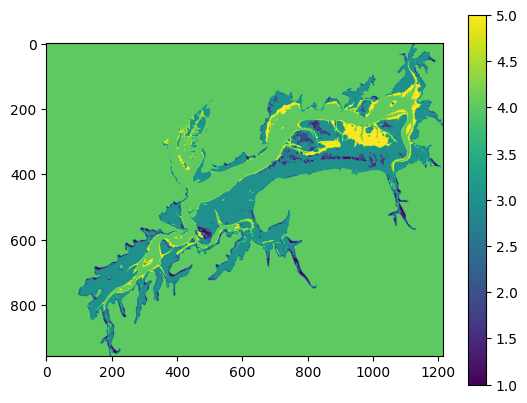

In [ ]:
plt.imshow(supervised_classification) # optional
plt.colorbar()

In [ ]:
raster = gdal.Open('/content/gdrive/My Drive/Whanganui/classification_ras.tif') ##open an old image because we want to use the spatial information of this image
geot = raster.GetGeoTransform()
proj = raster.GetProjectionRef()
filename = '/content/gdrive/My Drive/Whanganui/sc20211231.tif'
xsize = np.shape(supervised_classification)[1]
ysize = np.shape(supervised_classification)[0]

driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(filename, xsize, ysize, bands = 1, eType = gdal.GDT_UInt16)
dataset.GetRasterBand(1).WriteArray(supervised_classification)
dataset.SetGeoTransform(geot)
dataset.SetProjection(proj)

dataset.FlushCache()
dataset=None    ##Export the data

In [ ]:
import joblib
joblib.dump(randomforest,"/content/gdrive/My Drive/Whanganui/classification_model.joblib")

['/content/gdrive/My Drive/Whanganui/classification_model.joblib']